# Age, emotion and gender detection

Student: Marija Petrovic IT69-2019

Faculty of Technical Science, Novi Sad, Serbia

Face recognition and Face differentiation have always been innate capacities in humans. Computers can now
perform the same thing. This brings up a slew of human computers. Face detection and recognition can be used to
improve access and security, process payments without actual cards, identify criminals, and provide individualized
healthcare and other services. Face recognition is undoubtedly the most debated topic over extensive research in recent
decades, owing to rising security needs and its potential in commercial and law enforcement applications. [1]

[1] "Smart Facial Emotion Recognition With Gender and Age Factor
Estimation" - Surya Teja Chavalia, Charan Tej Kandavalli, Sugash T M, Subramani R



In [1]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1N3nXJ5PIhRqjhZ4Qf-xeqDvQM6IkQJpc' -O 'faged.7z'
!7z x 'faged.7z'
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1oqvYfoafMI4YrUbvQOV8eDWmh0K4KPJf' -O 'fer2013.7z'
!7z x 'fer2013.7z'
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1ijFu9ePdMZM2nTW7bwoj0RF2XrBFocqJ' -O 'modelnweight.7z'
!7z x 'modelnweight.7z'

will be placed in the single file you specified.

--2024-03-10 13:31:49--  https://docs.google.com/uc?export=download&id=1N3nXJ5PIhRqjhZ4Qf-xeqDvQM6IkQJpc
Resolving docs.google.com (docs.google.com)... 74.125.130.138, 74.125.130.100, 74.125.130.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.130.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1N3nXJ5PIhRqjhZ4Qf-xeqDvQM6IkQJpc&export=download [following]
--2024-03-10 13:31:49--  https://drive.usercontent.google.com/download?id=1N3nXJ5PIhRqjhZ4Qf-xeqDvQM6IkQJpc&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2537694 (2.4M) [application/octet-stream]
Saving to: ‘faged.7z’

faged.7z            100%[==

# Age and gender detection

**OpenCV** stands for "Open Source Computer Vision." As the name suggests, OpenCV is an open-source library used for real-time image and video processing while providing analytical capabilities. It supports popular deep learning frameworks such as TensorFlow, Caffe, and PyTorch.

A **Convolutional Neural Network** (CNN) is a type of deep neural network commonly used for image recognition and processing, as well as natural language processing (NLP). CNN, also known as ConvNet, consists of input and output layers along with multiple hidden layers, many of which utilize convolution. CNN can be seen as a regularized version of a multilayer perceptron.

In [2]:
# Adding the necessary modules:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

# Finding coordinates for the bounding box

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

# Loading files for the model and weights

faceProto = "/content/modelnweight/opencv_face_detector.pbtxt"
faceModel = "/content/modelnweight/opencv_face_detector_uint8.pb"

ageProto = "/content/modelnweight/age_deploy.prototxt"
ageModel = "/content/modelnweight/age_net.caffemodel"

genderProto = "/content/modelnweight/gender_deploy.prototxt"
genderModel = "/content/modelnweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
# List of years
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
# List of genders
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Reading a frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:

        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Predicting the age and gender of detected faces
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        # Drawing the results
        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

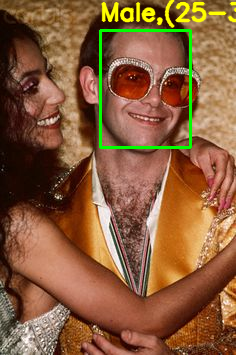

In [3]:
#Loading the image and displaying the results
input = cv.imread("/content/faged/train/elton_john/httpssmediacacheakpinimgcomxfcfcbaeaeddabbjpg.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

# Emotion detection

Key facial landmarks are extracted, and based on them, the emotion is recognized. An additional dataset was used for training since the original dataset was not initially intended for predicting emotions but rather faces.

In [4]:
!pip install tensorflow
!pip install keras

In [5]:
import numpy as np
import pandas as pd
import os

In [6]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Fetching data for training
filname = '/content/fer2013/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('/content/fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [8]:
# Fetching data from the file and storing it into lists

import numpy as np

def getData(filename):
    Y = []
    X = []

    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    length = len(X)
    i = 0
    X = np.array(X)
    while i < length:
        X[i] = [c/255.0 for c in X[i]]
        i += 1

    print(X.shape)
    Y = np.array(Y)
    return X, Y

In [9]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

(35887, 2304)
7


In [10]:
# Formating the images as 48x48.
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [11]:
from sklearn.model_selection import train_test_split

# Training : Validation : Test - 80:10:10

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [12]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers import BatchNormalization

We're crafting a sequential model.

The initial layer is tailored for input images, viewed as two-dimensional matrices. With 64 nodes and a 5x5 matrix, we employ the ReLU (Rectified Linear Activation) function—a proven performer in neural networks. MaxPooling2D layers are enlisted to downsize feature map dimensions, effectively curbing learning parameters and computational load.

A Flatten layer bridges between Conv2D and Dense layers. The Dense layer serves as our output hub. To stave off overfitting, we integrate a Dropout layer.

In the output layer, 7 nodes—each for a conceivable outcome—are embedded. With softmax activation, outputs sum up to 1, yielding a probability interpretation. The model then leverages the option with the highest probability for prediction.

Post-layer configuration, we compile the model.

Optimization control falls to Adam, regulating learning rate. For loss function, we opt for categorical_crossentropy, where a lower score signifies superior model performance. We track accuracy as a metric to gauge validation set precision during model training.

In [13]:
# Creating a CNN model and adding layers

def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

In [14]:
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

# Saves the model at this location for each epoch
path_model = 'model_filter.h5'

# Destroys the current graph and creates a new one
K.clear_session()

# Model creation
model = my_model()

# Adjusting the learning rate
K.set_value(model.optimizer.lr, 1e-4)


# Adding a Dropout layer
model.add(Dropout(0.5))

# Fitting the model with changes
h = model.fit(x=X_train,
              y=y_train,
              batch_size=64,
              epochs=20,
              verbose=1,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=[ModelCheckpoint(filepath=path_model)]
              )

Epoch 1/20
505/505 [==============================] - 33s 40ms/step - loss: nan - accuracy: 0.1980 - val_loss: 1.8109 - val_accuracy: 0.2658
Epoch 2/20
  1/505 [..............................] - ETA: 17s - loss: 8.2111 - accuracy: 0.2188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2102 - val_loss: 1.7992 - val_accuracy: 0.2714
Epoch 3/20
505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2086 - val_loss: 1.8219 - val_accuracy: 0.2692
Epoch 4/20
505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2111 - val_loss: 1.7916 - val_accuracy: 0.2708
Epoch 5/20
505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2148 - val_loss: 1.7885 - val_accuracy: 0.2675
Epoch 6/20
505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2148 - val_loss: 1.7868 - val_accuracy: 0.2675
Epoch 7/20
505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2142 - val_loss: 1.7826 - val_accuracy: 0.2678
Epoch 8/20
505/505 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2147 - val_loss: 1.7749 - val_accuracy: 0.2750
Epoch 9/20
505/505 [====

In [15]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


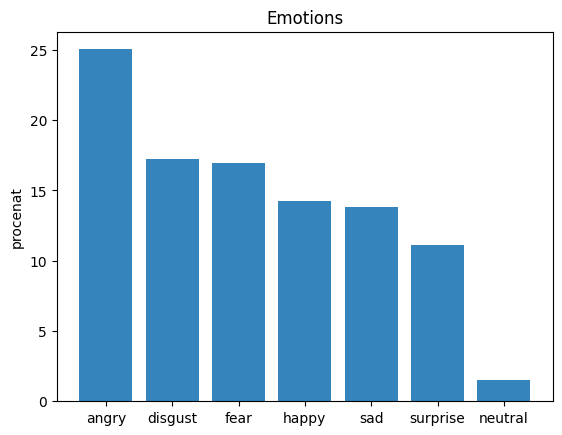

In [16]:
# Emotion analysis
import pandas as pd
import matplotlib.pyplot as plt

def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = range(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.xticks(y_pos, objects)
    plt.ylabel('procenat')
    plt.title('Emotions')

data = pd.read_csv('/content/fer2013/fer2013.csv')
emotions = data['emotion']

emotions_counts = emotions.value_counts()
emotions_percentages = emotions_counts / len(emotions) * 100

emotion_analysis(emotions_percentages)
plt.show()

In [17]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

113/113 [==============================] - 2s 7ms/step


(3589, 7)

1/1 [==============================] - 1s 527ms/step


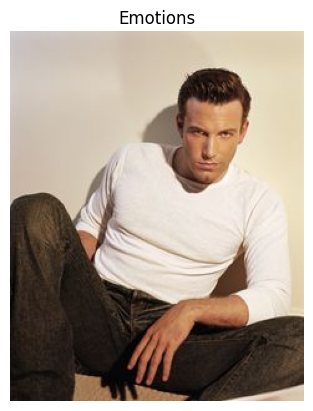

Expression Prediction: happy


In [18]:
import skimage
from skimage import io

# Image loading
img = io.imread('/content/faged/data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg', as_gray=True)
show_img = io.imread('/content/faged/data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg')

# Resizing the image
resized_img = skimage.transform.resize(img, (48, 48), anti_aliasing=True)

# Normalization 0.0-1.0
normalized_img = resized_img / 255.0

# Prediction
custom = model.predict(np.expand_dims(normalized_img, axis=0))
emotion_analysis(custom[0])

# Displaying the image
plt.imshow(show_img)
plt.axis('off')
plt.show()

# Printing the results
expression_index = np.argmax(custom[0])
print('Expression Prediction:', objects[expression_index])

# DeepFace Analysis

**Deep face** analysis refers to the use of advanced machine learning techniques, particularly deep learning, to analyze facial images in detail. It involves tasks such as facial recognition, emotion detection, age and gender estimation, facial attribute prediction, and facial landmark detection.

**Deep face** analysis algorithms typically operate by extracting intricate facial features and patterns from images, enabling applications in various fields like security, healthcare, entertainment, and marketing.

In [19]:
# Adding the necessary libraries

!pip install deepface
from deepface import DeepFace
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 12.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=57f186b969e1407324c32b33e2c44d36e296da3e69b2ab5e5425bd11bf11d4a3
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
24-03-10 13:43:04 - Directory /root/.deepface created
24-03-10 13:43:04 - Directory /root/.deepface/weights created


<function matplotlib.pyplot.show(close=None, block=None)>

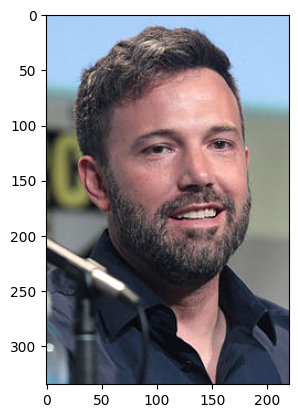

In [20]:
# Loading and displaying the image
img1=cv2.imread('/content/faged/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg')
plt.imshow(img1[:,:,::-1])
plt.show

In [21]:
# Analyzing gender, age and emotion and printing the results
result = DeepFace.analyze(img1, actions=['gender', 'age', 'emotion'], enforce_detection=False)
print("Gender: ", result[0]['gender'])
print("Age: ", result[0]['age'])
print("Emotion: ", result[0]['emotion'])

Action: gender:   0%|          | 0/3 [00:00<?, ?it/s] 

24-03-10 13:43:05 - gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  0%|          | 2.62M/537M [00:00<00:20, 25.6MB/s]
  4%|▎         | 19.4M/537M [00:00<00:04, 108MB/s] 
 10%|█         | 55.6M/537M [00:00<00:02, 223MB/s]
 17%|█▋        | 90.2M/537M [00:00<00:01, 270MB/s]
 23%|██▎       | 121M/537M [00:00<00:01, 283MB/s] 
 28%|██▊       | 149M/537M [00:00<00:01, 279MB/s]
 33%|███▎      | 178M/537M [00:00<00:01, 248MB/s]
 38%|███▊      | 203M/537M [00:00<00:01, 241MB/s]
 42%|████▏     | 228M/537M [00:00<00:01, 233MB/s]
 48%|████▊     | 257M/537M [00:01<00:01, 244MB/s]
 53%|█████▎    | 282M/537M [00:01<00:01, 231MB/s]
 57%|█████▋    | 307M/537M [00:01<00:00, 236MB/s]
 63%|██████▎   | 339M/537M [00:01<00:00, 255MB/s]
 68%|██████▊   | 364M/537M [00:01<00:00, 223MB/s]
 72%|███████▏  | 387M/537M [00:01<00:00, 204MB/s]
 76%|███████▌  | 409M/537M [00:01<0

24-03-10 13:43:13 - age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  1%|▏         | 6.82M/539M [00:00<00:07, 68.0MB/s]
  4%|▎         | 19.9M/539M [00:00<00:04, 105MB/s] 
  8%|▊         | 44.6M/539M [00:00<00:03, 153MB/s]
 11%|█         | 59.8M/539M [00:00<00:03, 152MB/s]
 15%|█▍        | 78.6M/539M [00:00<00:02, 163MB/s]
 18%|█▊        | 94.9M/539M [00:00<00:02, 159MB/s]
 21%|██        | 111M/539M [00:00<00:03, 140MB/s] 
 23%|██▎       | 126M/539M [00:00<00:03, 133MB/s]
 26%|██▋       | 142M/539M [00:01<00:02, 141MB/s]
 29%|██▉       | 158M/539M [00:01<00:02, 143MB/s]
 34%|███▍      | 186M/539M [00:01<00:01, 180MB/s]
 38%|███▊      | 204M/539M [00:01<00:01, 182MB/s]
 41%|████▏     | 223M/539M [00:01<00:02, 154MB/s]
 45%|████▍     | 240M/539M [00:01<00:02, 117MB/s]
 48%|████▊     | 260M/539M [00:01<00:02, 134MB/s]
 51%|█████▏    | 277M/539M [00:01<00:01

24-03-10 13:43:25 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

  0%|          | 0.00/5.98M [00:00<?, ?B/s]
100%|██████████| 5.98M/5.98M [00:00<00:00, 27.6MB/s]
Action: emotion: 100%|██████████| 3/3 [00:23<00:00,  7.92s/it]

Gender:  {'Woman': 0.0008031340257730335, 'Man': 99.99920129776001}
Age:  32
Emotion:  {'angry': 0.0035442344890497693, 'disgust': 1.0695196477554778e-05, 'fear': 2.120610639191308, 'happy': 22.03665060023371, 'sad': 0.2063311759430871, 'surprise': 0.18688742952495394, 'neutral': 75.4459664491395}


<function matplotlib.pyplot.show(close=None, block=None)>

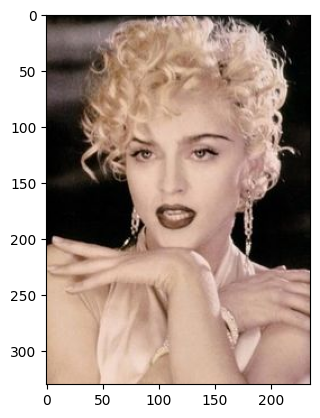

In [22]:
# Loading and displaying the image
img2=cv2.imread('/content/faged/train/madonna/httpssmediacacheakpinimgcomxdcfdcfedfaedadjpg.jpg')
plt.imshow(img2[:,:,::-1])
plt.show

In [23]:
# Analyzing gender, age, and emotion and printing the results
result = DeepFace.analyze(img2, actions=['gender', 'age', 'emotion'], enforce_detection=False)
print("Gender: ", result[0]['gender'])
print("Age: ", result[0]['age'])
print("Emotion: ", result[0]['emotion'])

Action: emotion: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

Gender:  {'Woman': 98.80224466323853, 'Man': 1.1977518908679485}
Age:  33
Emotion:  {'angry': 0.7939980365335941, 'disgust': 1.472145294556526e-07, 'fear': 4.724316298961639, 'happy': 0.00827031908556819, 'sad': 9.620663523674011, 'surprise': 1.7577381804585457, 'neutral': 83.0950140953064}


# Conclusion

By employing various techniques and algorithms, successful analysis of gender, age, and emotions in images has been conducted. The results presented can be utilized for further exploration in this field.

It is important to note that the accuracy of emotion, gender, and age detection may vary depending on the quality of the images used.

Furthermore, incorporating additional data or adjusting model parameters can further enhance the results.